<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snowmelt_prediction_with_SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Snow Melting Prediction with Supprt Vetctor Regression(SVR)

In [2]:
!pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Using TensorFlow backend


In [79]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [5]:
# features = ['Date',"Q","SCA","T",'P']
features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [6]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


<ipython-input-6-6a192a8b458d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


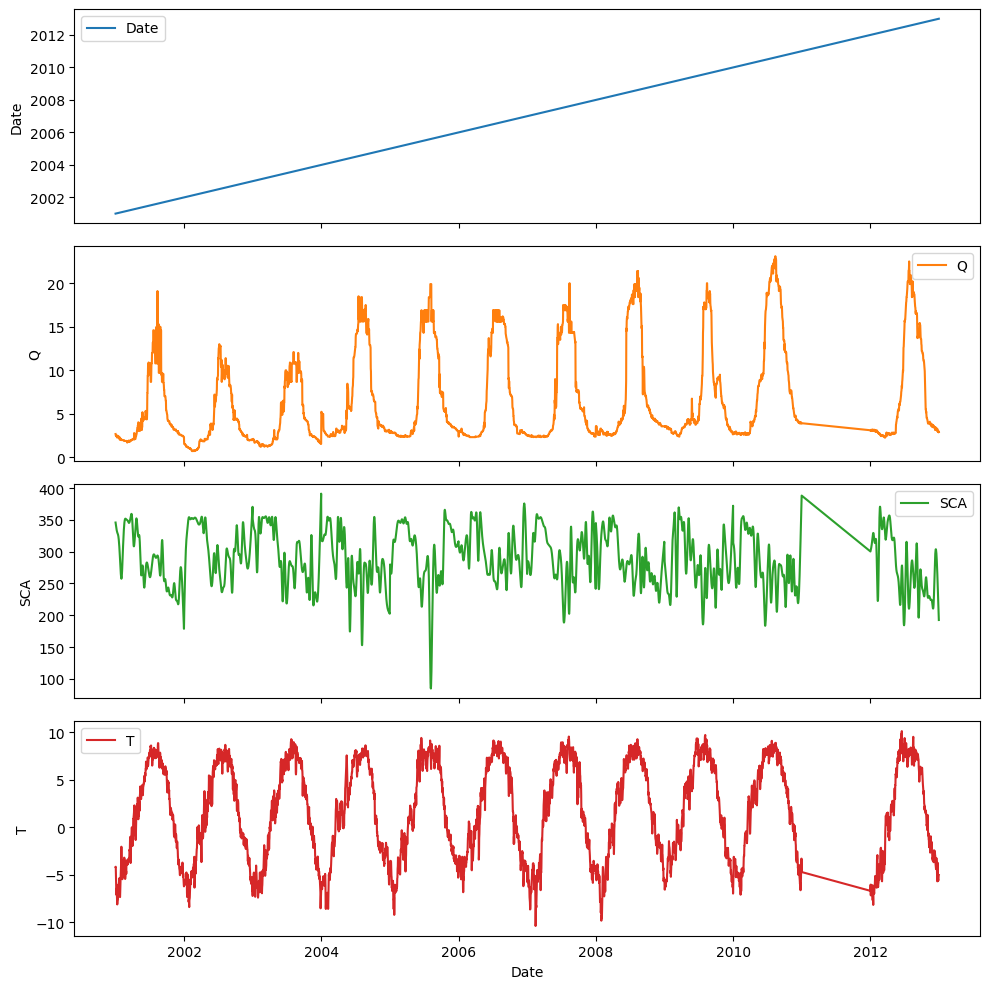

In [7]:

# Create subplots for each column
fig, axes = plt.subplots(len(features), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(features):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [66]:
# Normalize

df_input = df_snow_melting[features]


scaler = StandardScaler()

# Select the features you want to scale
features_to_scale = ['Q', 'SCA', 'T']

# Fit the scaler to the data and transform the selected features
df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [67]:
df_input = df_input[features_to_scale]
df_input

,Q,SCA,T
0,-0.714983,1.306925,-1.170123
1,-0.744452,1.255788,-1.164703
2,-0.744452,1.205464,-1.365690
3,-0.762871,1.156767,-1.640360
4,-0.744452,1.110509,-1.707563
...,...,...,...
4012,-0.674462,-1.409374,-1.466072
4013,-0.674462,-1.626085,-1.436107
4014,-0.652360,-1.839801,-1.441230
4015,-0.663411,-2.047526,-1.357451


In [73]:
X = df_input[['SCA','T']].values
y = df_input[['Q']].values

In [83]:

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [84]:
X.shape


(4015, 2, 3)

In [85]:
y[0]

-0.7444523738458673

In [86]:
n_samples, n_time_steps, n_features = X.shape
X = X.reshape(n_samples, -1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
model = SVR(kernel='rbf',epsilon=0.1)

In [111]:

model.fit(X_train,y_train)

SVR()

In [112]:
y_pred = model.predict(X_test)

MAE: 0.057897780230972085
RMSE: 0.11006838157184475
R-squared (R2): 0.9879414402366354


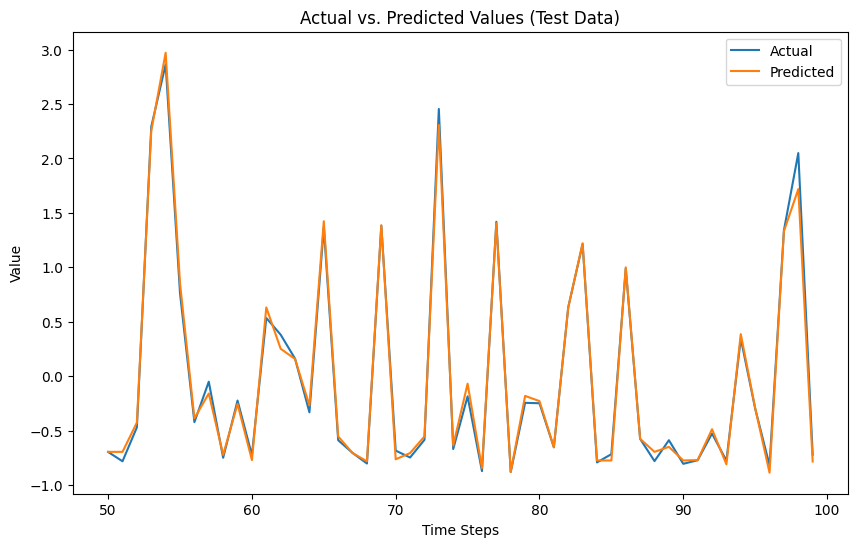

In [113]:
test_predictions = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})

plt.figure(figsize=(10, 6))
plt.plot(test_result['test Predictions'][50:100], label='Actual')
plt.plot(test_result['Actuals'][50:100], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

In [115]:
import numpy as np
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf'],
    # Add other hyperparameters for tuning
}

best_param = {
    "C": 0,
    "epsilon": 0,
    "kernel": 'linear',
}

best_model = None
best_score = float('inf')  # Initialize with a high value
nested_scores = []

# Perform Nested Cross-Validation
for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    # model = SVR()

    # for params in ParameterGrid(param_grid):
        # mse_scores = []

        # for train_ix_inner, val_ix in inner_cv.split(X_train):
        #     X_train_inner, X_val = X_train[train_ix_inner], X_train[val_ix]
        #     y_train_inner, y_val = y_train[train_ix_inner], y_train[val_ix]

        #     model.fit(X_train_inner, y_train_inner)
        #     y_pred = model.predict(X_val)
        #     mse = mean_squared_error(y_val, y_pred)
        #     mse_scores.append(mse)

        # mean_mse = np.mean(mse_scores)

        # if mean_mse < best_score:
        #     best_score = mean_mse
        #     best_model = model

    # Now that we have the best model, evaluate it on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    nested_scores.append({
        "MSE": mse,
        "R^2": r2,
        "RMSE": rmse,
        "MAE": mae
    })

# Calculate overall statistics
mean_mse = np.mean([scores['MSE'] for scores in nested_scores])
mean_r2 = np.mean([scores['R^2'] for scores in nested_scores])
mean_rmse = np.mean([scores['RMSE'] for scores in nested_scores])
mean_mae = np.mean([scores['MAE'] for scores in nested_scores])

print(f"Best Hyperparameters: C = {best_param['C']}, Epsilon = {best_param['epsilon']}, Kernel = {best_param['kernel']}")
print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")


Best Hyperparameters: C = 0, Epsilon = 0, Kernel = linear
Mean MSE: 0.009
Mean R^2: 0.991
Mean RMSE: 0.095
Mean MAE: 0.054


In [116]:
for fold, scores in enumerate(nested_scores):
    print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")


Fold 1 - MSE: 0.012, MAE: 0.058,RMSE: 0.110, R^2: 0.988
Fold 2 - MSE: 0.009, MAE: 0.052,RMSE: 0.093, R^2: 0.991
Fold 3 - MSE: 0.008, MAE: 0.053,RMSE: 0.091, R^2: 0.991
Fold 4 - MSE: 0.009, MAE: 0.055,RMSE: 0.095, R^2: 0.991
Fold 5 - MSE: 0.007, MAE: 0.052,RMSE: 0.085, R^2: 0.993


In [42]:
import joblib
joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/model/SVR_model_inout_3.pkl')
# best_model.save('/content/drive/MyDrive/Colab Notebooks/model/SVR_model_inout_3.h5')

['/content/drive/MyDrive/Colab Notebooks/model/SVR_model_inout_3.pkl']

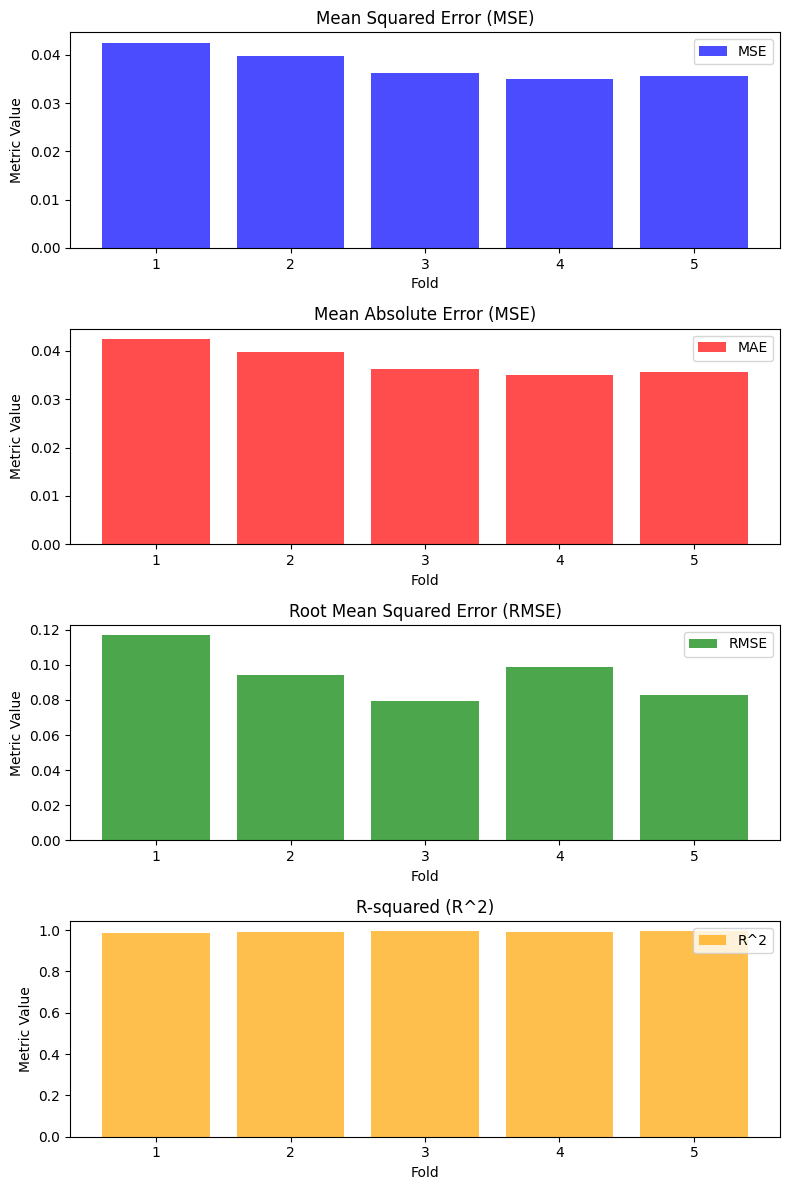

In [43]:
import matplotlib.pyplot as plt

# Extract the metrics from the nested_scores list
fold_numbers = range(1, len(nested_scores) + 1)
mse_values = [score['MSE'] for score in nested_scores]
mse_values = [score['MAE'] for score in nested_scores]
rmse_values = [score['RMSE'] for score in nested_scores]
r2_values = [score['R^2'] for score in nested_scores]

# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(8, 12))

# Create bar plots for each metric
axs[0].bar(fold_numbers, mse_values, color='blue', alpha=0.7, label='MSE')
axs[0].set_title('Mean Squared Error (MSE)')

axs[1].bar(fold_numbers, mse_values, color='red', alpha=0.7, label='MAE')
axs[1].set_title('Mean Absolute Error (MSE)')

axs[2].bar(fold_numbers, rmse_values, color='green', alpha=0.7, label='RMSE')
axs[2].set_title('Root Mean Squared Error (RMSE)')

axs[3].bar(fold_numbers, r2_values, color='orange', alpha=0.7, label='R^2')
axs[3].set_title('R-squared (R^2)')

# Add labels and legends
for ax in axs:
    ax.set_xlabel('Fold')
    ax.set_ylabel('Metric Value')
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [80]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your multivariate time series data into a pandas DataFrame with timestamps
# Replace this with your actual data loading code
# For demonstration, we'll generate a simple multivariate time series dataset
date_rng = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
data = {
    'Feature1': np.sin(np.arange(len(date_rng))) + np.random.normal(0, 0.2, len(date_rng)),
    'Feature2': np.cos(np.arange(len(date_rng))) + np.random.normal(0, 0.2, len(date_rng))
}
df = pd.DataFrame({'Date': date_rng, 'Feature1': data['Feature1'], 'Feature2': data['Feature2']})

# Define the forecasting horizon
forecast_horizon = 7  # Forecast the next 7 days

# Data Preprocessing
# Create lag features for both features
for i in range(1, forecast_horizon + 1):
    for feature in ['Feature1', 'Feature2']:
        df[f'{feature}_lag_{i}'] = df[feature].shift(-i)

# Drop rows with missing values
df.dropna(inplace=True)

# Split data into training and testing sets
train_size = int(0.8 * len(df))
train_data, test_data = df[:train_size], df[train_size:]

# Features and target variable
input_features = ['Feature1_lag_1', 'Feature1_lag_2', 'Feature2_lag_1', 'Feature2_lag_2']
X_train, y_train = train_data[input_features], train_data[['Feature1', 'Feature2']]
X_test, y_test = test_data[input_features], test_data[['Feature1', 'Feature2']]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVR Model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Forecast using SVR
forecast = svr_model.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], y_test['Feature1'], label='Actual Feature1')
plt.plot(test_data['Date'], forecast[:, 0], label='Forecast Feature1', linestyle='--')
plt.plot(test_data['Date'], y_test['Feature2'], label='Actual Feature2')
plt.plot(test_data['Date'], forecast[:, 1], label='Forecast Feature2', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Multivariate SVR Time Series Forecasting')
plt.show()


ValueError: ignored